# Calibration Tutorial - Crane, OR - Irrigated Flux Plot

## Step 3: Running the Calibrated Model

Now we evaluate whether calibration improved model performance by running in **forecast mode** with calibrated parameters.

This notebook:
1. Visualizes how parameters evolved during calibration
2. Runs the model with calibrated parameters
3. Compares calibrated vs uncalibrated performance against flux tower observations
4. Reports multiple metrics (R², Pearson r, RMSE, bias) for both capture dates and full time series

In [ ]:
import os
import sys
import time
import tempfile

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../..')
sys.path.append(root)

from swimrs.swim.config import ProjectConfig
from swimrs.container import SwimContainer
from swimrs.process.input import build_swim_input
from swimrs.process.loop_fast import run_daily_loop_fast

from swimrs.viz.param_evolution import plot_parameter_histograms
from swimrs.viz.swim_timeseries import plot_swim_timeseries

%matplotlib inline

In [ ]:
project_ws = os.path.abspath('.')
data = os.path.join(project_ws, 'data')
pestrun = os.path.join(data, 'pestrun')
pest_dir = os.path.join(pestrun, 'pest')

config_file = os.path.join(project_ws, '3_Crane.toml')

## 1. Visualize Parameter Evolution

Let's see how the parameters changed across optimization iterations. The histograms show the distribution of parameter values across ensemble realizations.

In [ ]:
initial_params = os.path.join(pestrun, 'params.csv')

# Get all parameter files from optimization steps
steps = []
for i in range(10):  # Check up to 10 iterations
    step_file = os.path.join(pest_dir, f'3_Crane.{i}.par.csv')
    if os.path.exists(step_file):
        steps.append(step_file)

if steps:
    print(f"Found {len(steps)} optimization steps")
    
    fig_dir = os.path.join(project_ws, 'figures', 'parameter_hist')
    os.makedirs(fig_dir, exist_ok=True)
    
    # Plot histograms (set fig_out_dir=fig_dir to save PNGs)
    plot_parameter_histograms(initial_params, steps, fig_out_dir=None)
else:
    print("No parameter files found. Run notebook 02_calibration first.")

## 2. Run the Calibrated Model

To run with calibrated parameters:
1. Set `forecast=True` when reading config
2. Ensure `[forecast]` section in config points to the final `.par.csv` file

The config file should have:
```toml
[forecast]
forecast_parameters = "{pest_run_dir}/pest/3_Crane.3.par.csv"
```

In [ ]:
def run_fields(config, container, selected_feature, output_csv, forecast=False):
    """Run SWIM model using the process package and save output to CSV.
    
    Uses the modern process package workflow:
    1. Build SwimInput from container (with calibrated params if forecast=True)
    2. Run simulation with run_daily_loop_fast()
    3. Convert DailyOutput to DataFrame with time series
    4. Add ETf observations from container for comparison
    """
    start_time = time.time()

    # Create temporary HDF5 for SwimInput
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as tmp:
        temp_h5_path = tmp.name
    
    # Handle calibrated parameters for forecast mode
    calibrated_params_path = None
    if forecast:
        # Read forecast parameters and convert to JSON
        config.read_forecast_parameters()
        if hasattr(config, 'forecast_parameters') and config.forecast_parameters is not None:
            calibrated_params_path = _convert_forecast_params_to_json(
                config.forecast_parameters, 
                os.path.dirname(output_csv)
            )
    
    try:
        # Build SwimInput from container
        swim_input = build_swim_input(
            container,
            output_h5=temp_h5_path,
            calibrated_params_path=calibrated_params_path,
            runoff_process=getattr(config, 'runoff_process', 'cn'),
            etf_model=getattr(config, 'etf_target_model', 'ssebop'),
            met_source=getattr(config, 'met_source', 'gridmet'),
            fields=[selected_feature],
        )
        
        # Run simulation (uses fast JIT-compiled loop)
        output, final_state = run_daily_loop_fast(swim_input)
        
        # Get time series data
        n_days = swim_input.n_days
        dates = pd.date_range(swim_input.start_date, periods=n_days, freq='D')
        
        # Get input time series for DataFrame
        etr = swim_input.get_time_series('etr')
        prcp = swim_input.get_time_series('prcp')
        tmin = swim_input.get_time_series('tmin')
        tmax = swim_input.get_time_series('tmax')
        ndvi = swim_input.get_time_series('ndvi')
        
        # Build DataFrame (field index 0 since we're doing single field)
        i = 0
        df_data = {
            # Model outputs
            'et_act': output.eta[:, i],
            'etref': etr[:, i],
            'kc_act': output.etf[:, i],
            'kc_bas': output.kcb[:, i],
            'ks': output.ks[:, i],
            'ke': output.ke[:, i],
            'melt': output.melt[:, i],
            'rain': output.rain[:, i],
            'depl_root': output.depl_root[:, i],
            'dperc': output.dperc[:, i],
            'runoff': output.runoff[:, i],
            'swe': output.swe[:, i],
            'irrigation': output.irr_sim[:, i],
            'gw_sim': output.gw_sim[:, i],
            # Input time series
            'ppt': prcp[:, i],
            'tmin': tmin[:, i],
            'tmax': tmax[:, i],
            'tavg': (tmin[:, i] + tmax[:, i]) / 2.0,
            'ndvi': ndvi[:, i],
        }
        
        # Calculate derived columns
        df_data['soil_water'] = swim_input.properties.awc[i] - output.depl_root[:, i]
        
        df = pd.DataFrame(df_data, index=dates)
        
        swim_input.close()
        
        # Load ETf observations from container for comparison
        etf_model = getattr(config, 'etf_target_model', 'ssebop')
        
        for mask in ['inv_irr', 'irr']:
            if etf_model == 'ensemble':
                # Compute ensemble mean from all available models
                known_models = ['ssebop', 'ptjpl', 'sims', 'geesebal', 'eemetric', 'disalexi']
                mask_data = []
                for model in known_models:
                    etf_path = f"remote_sensing/etf/landsat/{model}/{mask}"
                    try:
                        etf_df = container.query.dataframe(etf_path, fields=[selected_feature])
                        if selected_feature in etf_df.columns:
                            mask_data.append(etf_df[selected_feature])
                    except Exception:
                        pass
                
                if mask_data:
                    combined = pd.concat(mask_data, axis=1)
                    ensemble_mean = combined.mean(axis=1)
                    etf_series = ensemble_mean.reindex(dates)
                    df[f'etf_{mask}'] = etf_series.values
                    print(f"Loaded ensemble ETf for {mask} from {len(mask_data)} models")
                else:
                    print(f"Warning: No ETf models found for {mask}")
                    df[f'etf_{mask}'] = np.nan
            else:
                etf_path = f"remote_sensing/etf/landsat/{etf_model}/{mask}"
                try:
                    etf_df = container.query.dataframe(etf_path, fields=[selected_feature])
                    etf_series = etf_df[selected_feature].reindex(dates)
                    df[f'etf_{mask}'] = etf_series.values
                except Exception as e:
                    print(f"Warning: Could not load ETf for {mask}: {e}")
                    df[f'etf_{mask}'] = np.nan
        
    finally:
        # Clean up temp files
        if os.path.exists(temp_h5_path):
            os.remove(temp_h5_path)
        if calibrated_params_path and os.path.exists(calibrated_params_path):
            os.remove(calibrated_params_path)
    
    end_time = time.time()
    print(f'\nExecution time: {end_time - start_time:.2f} seconds\n')

    df.to_csv(output_csv)
    
    return df


def _convert_forecast_params_to_json(forecast_params, out_dir: str) -> str:
    """Convert forecast_parameters Series to JSON format for build_swim_input.

    The forecast_parameters Series has index like 'kc_max_FID1', 'ndvi_k_FID1', etc.
    We convert to: {FID1: {kc_max: val, ndvi_k: val, ...}, ...}
    """
    import json
    import tempfile

    params_by_fid = {}
    for param_name in forecast_params.index:
        # Parse param name: expect format like 'kc_max_FID1' or 'ndvi_k_FID1'
        parts = param_name.rsplit('_', 1)
        if len(parts) == 2:
            base_param, fid = parts
            if fid not in params_by_fid:
                params_by_fid[fid] = {}
            params_by_fid[fid][base_param] = float(forecast_params[param_name])

    # Write to temp JSON file
    fd, json_path = tempfile.mkstemp(suffix='.json', prefix='calib_params_', dir=out_dir)
    os.close(fd)
    with open(json_path, 'w') as f:
        json.dump(params_by_fid, f)

    return json_path

In [ ]:
selected_feature = 'S2'
out_csv = os.path.join(project_ws, f'combined_output_{selected_feature}_calibrated.csv')

# Open container for model run
container_path = os.path.join(data, '3_Crane.swim')
container = SwimContainer.open(container_path, mode='r')

# Load config with forecast=True to get calibrated parameter path
config = ProjectConfig()
config.read_config(config_file, project_ws, forecast=True)

try:
    # Run with forecast=True to use calibrated parameters
    df = run_fields(config, container, selected_feature=selected_feature, 
                    output_csv=out_csv, forecast=True)
finally:
    container.close()

## 3. Visualize Calibrated Output

In [ ]:
ydf = df.loc['2004-01-01': '2004-12-31']
print(f'Total irrigation: {ydf.irrigation.sum():.1f} mm')
print(f'Total ET: {ydf.et_act.sum():.1f} mm')
print(f'Total precipitation: {ydf.ppt.sum():.1f} mm')

plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'], 
                     start='2004-01-01', end='2004-12-31', png_dir='et_calibrated.png')

## 4. Compare with Flux Tower Observations

We compare three estimates of actual ET (mm/day):

1. **SWIM ET**: Model-estimated actual evapotranspiration (daily)
2. **OpenET Ensemble ET**: Remote sensing retrievals from OpenET (PT-JPL, SIMS, SSEBop, geeSEBAL) averaged together (ETf x ETo)
3. **Flux ET**: Independent observations from the S2 eddy covariance tower

We show two comparisons:
- **Capture dates only**: Both methods compared only on Landsat overpass dates
- **Full time series**: SWIM (daily) vs OpenET (interpolated between Landsat dates) on all flux tower days

In [ ]:
def compare_et_estimates(combined_output_path, flux_data_path, irr=True):
    """Compare model ET and OpenET ensemble ET against flux tower observations.
    
    Returns two comparison DataFrames:
    1. Capture dates only: Both methods on Landsat overpass dates only
    2. Full time series: SWIM daily, OpenET interpolated, on all flux tower days
    
    Reports R², Pearson r, bias, and RMSE for each comparison.
    """
    flux_data = pd.read_csv(flux_data_path, index_col='date', parse_dates=True)
    flux_et = flux_data['ET']  # Actual ET from flux tower (mm/day)

    output = pd.read_csv(combined_output_path, index_col=0)
    output.index = pd.to_datetime(output.index)

    # Determine suffix based on irrigation mask
    mask_suffix = 'irr' if irr else 'inv_irr'
    
    # OpenET ensemble models - compute mean ETf across available models
    ensemble_models = ['ptjpl', 'sims', 'ssebop', 'geesebal']
    etf_cols = []
    for model in ensemble_models:
        col_name = f'etf_{model}_{mask_suffix}'
        if col_name in output.columns:
            etf_cols.append(col_name)
    
    # Fallback to single SSEBop if ensemble columns not available
    if not etf_cols:
        etf_col = f'etf_{mask_suffix}'
        if etf_col in output.columns:
            etf_cols = [etf_col]
            print(f"Using single ETf column: {etf_col}")
        else:
            print(f"Warning: No ETf columns found for mask '{mask_suffix}'")
            return pd.DataFrame(), pd.DataFrame()
    
    print(f"Using ETf columns: {etf_cols}")
    
    # Compute ensemble mean ETf (ignoring NaN)
    ensemble_etf = output[etf_cols].mean(axis=1, skipna=True)
    
    # Calculate actual ET from OpenET ensemble: ETf x ETo (sparse, only on Landsat dates)
    openet_et_sparse = ensemble_etf * output['etref']
    
    # Linear interpolation of OpenET to get daily values
    openet_et_interp = openet_et_sparse.interpolate(method='linear')
    
    # Count original OpenET observations
    n_openet_obs = openet_et_sparse.notna().sum()

    # CAPTURE DATES ONLY comparison (OpenET sparse)
    capture_df = pd.DataFrame({
        'swim_et': output['et_act'],
        'openet_et': openet_et_sparse,
        'flux_et': flux_et
    }).dropna()

    # FULL TIME SERIES comparison (OpenET interpolated)
    full_df = pd.DataFrame({
        'swim_et': output['et_act'],
        'openet_et': openet_et_interp,
        'flux_et': flux_et
    }).dropna()

    def calc_metrics(df, col1, col2):
        r, _ = stats.pearsonr(df[col1], df[col2])
        r2 = r2_score(df[col1], df[col2])
        rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
        bias = (df[col2] - df[col1]).mean()
        return r2, r, rmse, bias

    # Capture dates metrics
    r2_swim_cap, r_swim_cap, rmse_swim_cap, bias_swim_cap = calc_metrics(capture_df, 'flux_et', 'swim_et')
    r2_openet_cap, r_openet_cap, rmse_openet_cap, bias_openet_cap = calc_metrics(capture_df, 'flux_et', 'openet_et')

    # Full time series metrics
    r2_swim_full, r_swim_full, rmse_swim_full, bias_swim_full = calc_metrics(full_df, 'flux_et', 'swim_et')
    r2_openet_full, r_openet_full, rmse_openet_full, bias_openet_full = calc_metrics(full_df, 'flux_et', 'openet_et')

    print("="*70)
    print(f"CAPTURE DATES ONLY ({len(capture_df)} Landsat overpass dates)")
    print("="*70)
    print(f"{'Metric':<12} {'SWIM ET':>12} {'OpenET ET':>12}")
    print("-" * 38)
    print(f"{'R²':<12} {r2_swim_cap:>12.3f} {r2_openet_cap:>12.3f}")
    print(f"{'Pearson r':<12} {r_swim_cap:>12.3f} {r_openet_cap:>12.3f}")
    print(f"{'Bias (mm)':<12} {bias_swim_cap:>12.3f} {bias_openet_cap:>12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_swim_cap:>12.3f} {rmse_openet_cap:>12.3f}")
    
    print()
    print("="*70)
    print(f"FULL TIME SERIES ({len(full_df)} days, OpenET interpolated from {n_openet_obs} obs)")
    print("="*70)
    print(f"{'Metric':<12} {'SWIM ET':>12} {'OpenET ET':>12}")
    print("-" * 38)
    print(f"{'R²':<12} {r2_swim_full:>12.3f} {r2_openet_full:>12.3f}")
    print(f"{'Pearson r':<12} {r_swim_full:>12.3f} {r_openet_full:>12.3f}")
    print(f"{'Bias (mm)':<12} {bias_swim_full:>12.3f} {bias_openet_full:>12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_swim_full:>12.3f} {rmse_openet_full:>12.3f}")

    return full_df, capture_df

In [ ]:
# Use irrigated mask since this is an irrigated site
flux_data = os.path.join(data, 'S2_daily_data.csv')
full_df, capture_df = compare_et_estimates(out_csv, flux_data, irr=True)

### Compare Calibrated vs Uncalibrated Results

Let's compare the calibrated results with the uncalibrated baseline to see how much calibration improved performance.

In [ ]:
uncal_csv = os.path.join(project_ws, f'combined_output_{selected_feature}_uncalibrated.csv')

if os.path.exists(uncal_csv):
    print("UNCALIBRATED RESULTS:")
    print("-" * 70)
    full_df_uncal, capture_df_uncal = compare_et_estimates(uncal_csv, flux_data, irr=True)
    
    # Calculate improvement metrics (using full time series)
    def calc_metrics(df, col1, col2):
        r, _ = stats.pearsonr(df[col1], df[col2])
        r2 = r2_score(df[col1], df[col2])
        rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
        bias = (df[col2] - df[col1]).mean()
        return r2, r, rmse, bias

    r2_cal, r_cal, rmse_cal, bias_cal = calc_metrics(full_df, 'flux_et', 'swim_et')
    r2_uncal, r_uncal, rmse_uncal, bias_uncal = calc_metrics(full_df_uncal, 'flux_et', 'swim_et')
    
    print(f"\n" + "="*70)
    print("CALIBRATION IMPROVEMENT SUMMARY (Full Time Series)")
    print("="*70)
    print(f"{'Metric':<12} {'Uncalibrated':>15} {'Calibrated':>15} {'Change':>12}")
    print("-" * 56)
    print(f"{'R²':<12} {r2_uncal:>15.3f} {r2_cal:>15.3f} {r2_cal - r2_uncal:>+12.3f}")
    print(f"{'Pearson r':<12} {r_uncal:>15.3f} {r_cal:>15.3f} {r_cal - r_uncal:>+12.3f}")
    print(f"{'Bias (mm)':<12} {bias_uncal:>15.3f} {bias_cal:>15.3f} {bias_cal - bias_uncal:>+12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_uncal:>15.3f} {rmse_cal:>15.3f} {rmse_cal - rmse_uncal:>+12.3f}")
else:
    print("Uncalibrated output not found. Run notebook 01 first.")
    full_df_uncal = None

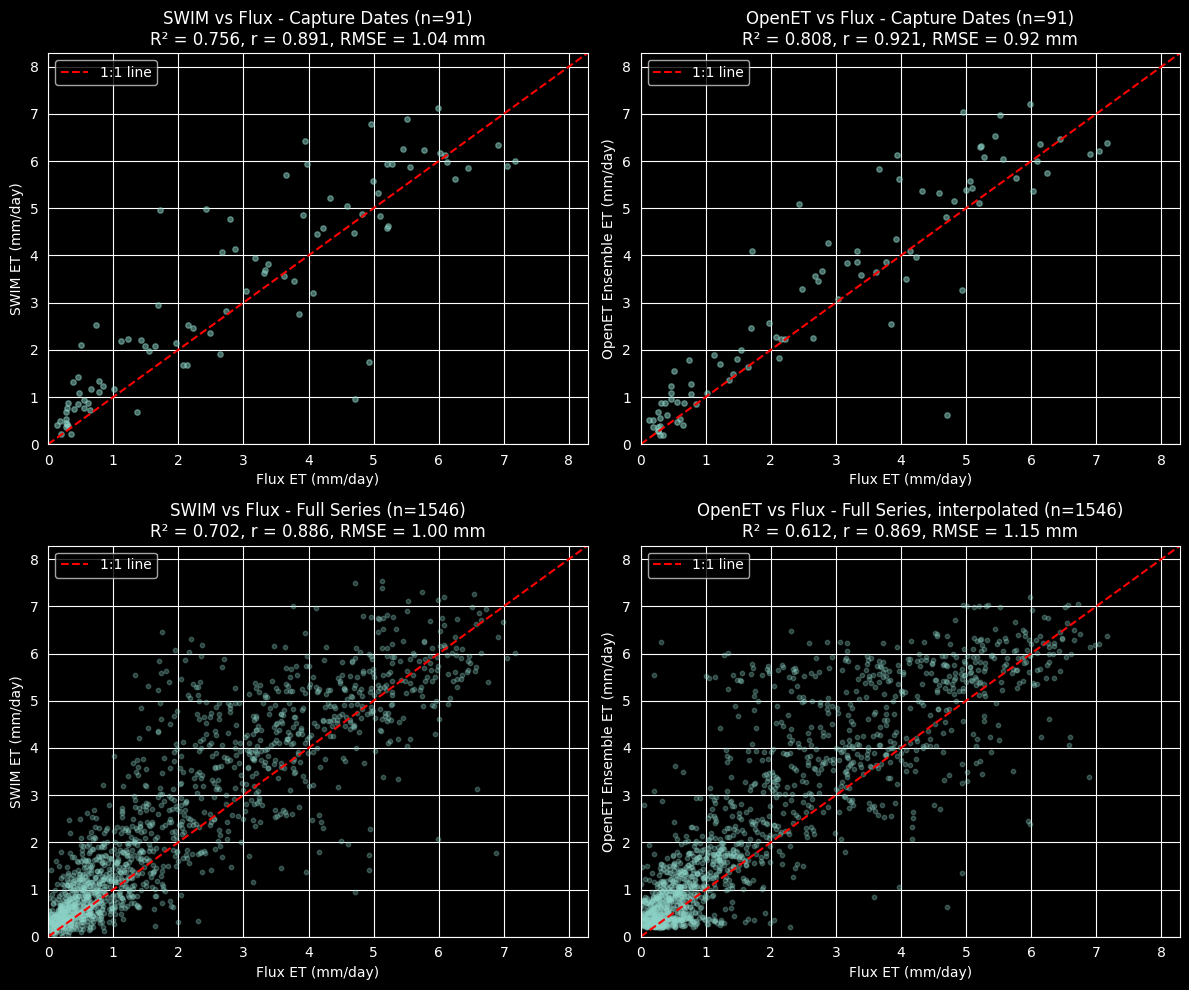

In [11]:
import matplotlib.pyplot as plt

# Create 2x2 scatter plots for both comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Helper function to calculate metrics
def calc_metrics(df, col1, col2):
    r, _ = stats.pearsonr(df[col1], df[col2])
    r2 = r2_score(df[col1], df[col2])
    rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
    return r2, r, rmse

# Determine axis limits
max_et = max(full_df['flux_et'].max(), full_df['swim_et'].max(), 
             full_df['openet_et'].max()) * 1.1

# TOP ROW: Capture dates only
r2_swim_cap, r_swim_cap, rmse_swim_cap = calc_metrics(capture_df, 'flux_et', 'swim_et')
r2_openet_cap, r_openet_cap, rmse_openet_cap = calc_metrics(capture_df, 'flux_et', 'openet_et')

ax = axes[0, 0]
ax.scatter(capture_df['flux_et'], capture_df['swim_et'], alpha=0.5, s=15)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('SWIM ET (mm/day)')
ax.set_title(f'SWIM vs Flux - Capture Dates (n={len(capture_df)})\n'
             f'R² = {r2_swim_cap:.3f}, r = {r_swim_cap:.3f}, RMSE = {rmse_swim_cap:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

ax = axes[0, 1]
ax.scatter(capture_df['flux_et'], capture_df['openet_et'], alpha=0.5, s=15)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('OpenET Ensemble ET (mm/day)')
ax.set_title(f'OpenET vs Flux - Capture Dates (n={len(capture_df)})\n'
             f'R² = {r2_openet_cap:.3f}, r = {r_openet_cap:.3f}, RMSE = {rmse_openet_cap:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

# BOTTOM ROW: Full time series comparison
r2_swim, r_swim, rmse_swim = calc_metrics(full_df, 'flux_et', 'swim_et')
r2_openet, r_openet, rmse_openet = calc_metrics(full_df, 'flux_et', 'openet_et')

ax = axes[1, 0]
ax.scatter(full_df['flux_et'], full_df['swim_et'], alpha=0.3, s=10)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('SWIM ET (mm/day)')
ax.set_title(f'SWIM vs Flux - Full Series (n={len(full_df)})\n'
             f'R² = {r2_swim:.3f}, r = {r_swim:.3f}, RMSE = {rmse_swim:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

ax = axes[1, 1]
ax.scatter(full_df['flux_et'], full_df['openet_et'], alpha=0.3, s=10)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('OpenET Ensemble ET (mm/day)')
ax.set_title(f'OpenET vs Flux - Full Series, interpolated (n={len(full_df)})\n'
             f'R² = {r2_openet:.3f}, r = {r_openet:.3f}, RMSE = {rmse_openet:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

plt.tight_layout()
plt.savefig('comparison_scatter_calibrated.png', dpi=150)
plt.show()

## Key Insights

Calibration improves model performance for this irrigated site. The improvement summary table shows how each metric changed from uncalibrated to calibrated.

### Two comparison modes

- **Capture dates**: Only Landsat overpass dates where we have satellite observations
- **Full time series**: All flux tower days, with OpenET values interpolated between satellite dates

### Why does this work?

**The key insight is that we can mine the deep remote sensing-based ET record, but rather than driving the model with remote sensing ET directly, we drive the calibration with it.**

The model has access to:
1. Daily meteorological data (not just satellite overpass days)
2. Physically-based soil water balance constraints
3. Flexibility to tune parameters using the remote sensing record

This combination gives SWIM a more grounded perspective on daily fluxes than remote sensing alone, resulting in better ET estimates.

### For irrigated sites

The calibration is particularly important for irrigated sites because:
- Default irrigation scheduling parameters may not match actual practices
- The NDVI-to-Kcb relationship varies by crop type (alfalfa vs. other crops)
- Soil parameters affect how quickly the model triggers irrigation

By calibrating against the OpenET ensemble ETf, the model learns the irrigation patterns and crop responses specific to this site.